# Introduction to Helmi with Qiskit

Helmi is a 5 qubit Quantum Computer that is co-developed by [VTT](https://www.vttresearch.com/en/ourservices/quantum-technology) and [IQM](https://www.meetiqm.com/). It uses superconducting transmon qubits in a star shaped topology. Helmi's natives gates consist of the phased-rx and controlled-z gates. This architecture is called **Adonis** by IQM.

In this tutorial running on Helmi is demonstrated using the Qiskit framework. You can also run on Helmi using [Cirq](https://quantumai.google/cirq) with [cirq-on-iqm](https://github.com/iqm-finland/cirq-on-iqm) adapter, and this is described in a separate notebook.  

Here is Helmi!

<div style="text-align:center">
<img src="../../img/large_helmi.jpg" alt="alt text" width="900" height="500" class="blog-image">
</div>

## Setup

This notebook uses the following requirements. 

```text
qiskit-iqm==13.16
iqm-client==18.8
qiskit[visualization]
pylatexenc
networkx
```

## Using Helmi with Qiskit

First we import [qiskit-on-iqm](https://github.com/iqm-finland/qiskit-on-iqm/tree/9.0) which is needed to run on Helmi with qiskit. You can read the user guide [here](https://iqm-finland.github.io/qiskit-on-iqm/versions/9.0/index.html).

In [16]:
import networkx as nx
from iqm.qiskit_iqm import IQMProvider
from iqm.qiskit_iqm.iqm_transpilation import optimize_single_qubit_gates
from qiskit import QuantumCircuit, QuantumRegister,transpile 
from qiskit.visualization import plot_histogram

##TODO: from qiskit.tools import job_monitor

import os ##TODO: REMOVE
from qiskit.tools.monitor import job_monitor

ModuleNotFoundError: No module named 'qiskit.tools'

Then connection to the backend is simple! For this we point the `IQMProvider` at Helmi URL. The Helmi URL is present in the environment variable and should be loaded as provided below. 

In [2]:
os.environ["HELMI_CORTEX_URL"] = "https://vttqx-staging.vtt.fi/api/devices/helmi"
os.environ["IQM_TOKEN"] = '4912ee641c4e6678890d95e1c93b4e78377607dee6e094257ae2f770cddbf070'
# TODO: REMOVE

In [9]:
provider = IQMProvider(os.environ["HELMI_CORTEX_URL"])
backend = provider.get_backend()

Now that we have the backend connected to Helmi, let's print out some information about Helmi!

In [6]:
print(f"Native operations: {backend.operation_names}")
print(f"Number of qubits: {backend.num_qubits}")
print(f"Coupling map: {backend.coupling_map}")

Native operations: ['r', 'id', 'cz', 'measure']
Number of qubits: 5
Coupling map: [[0, 2], [2, 0], [1, 2], [2, 1], [2, 3], [3, 2], [2, 4], [4, 2]]


Visualising the topology with `networkx`:

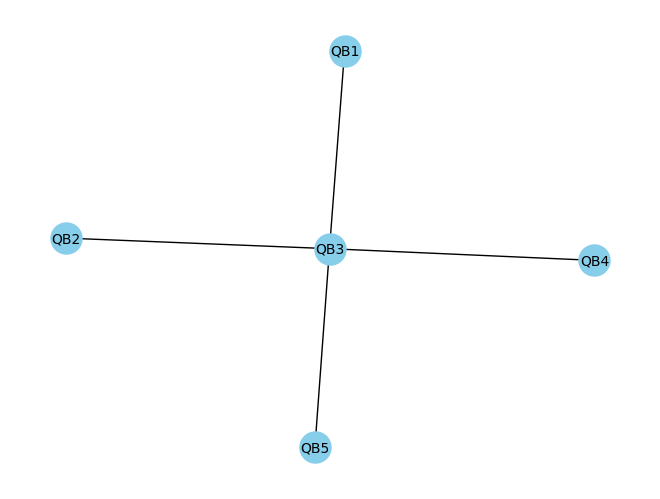

In [10]:
G = nx.Graph()
G.add_edges_from(backend.coupling_map)
node_labels = {node: f"QB{node + 1}" for node in G.nodes}
nx.draw(G, labels=node_labels, node_color="skyblue", node_size=500, font_size=10)

### Constructing and executing quantum circuits

Circuits are constructed and submitted to Helmi using the same methods as with IBM machines. First we construct a Bell pair circuit between 2 qubits. The circuit is then executed on the backend using the `backend.run` function. 

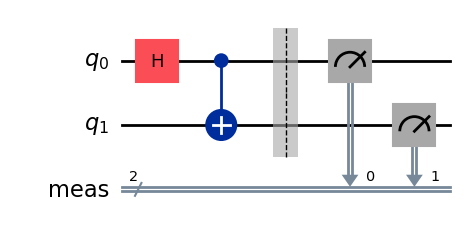

In [22]:
circuit = QuantumCircuit(2, name="Bell pair circuit")
circuit.h(0)
circuit.cx(0, 1)
circuit.measure_all()
circuit.draw(output="mpl")

### Executing the circuit on Helmi
We now transpile the circuit to rewrite the circuit based on the Helmi topology. Earlier, the qiskit execute automatically transpiled the circuits before running in the backend, but it has since been deprecated in qiskit 1.0+. We can even view the transpiled circuit before running the circuit now as shown: 

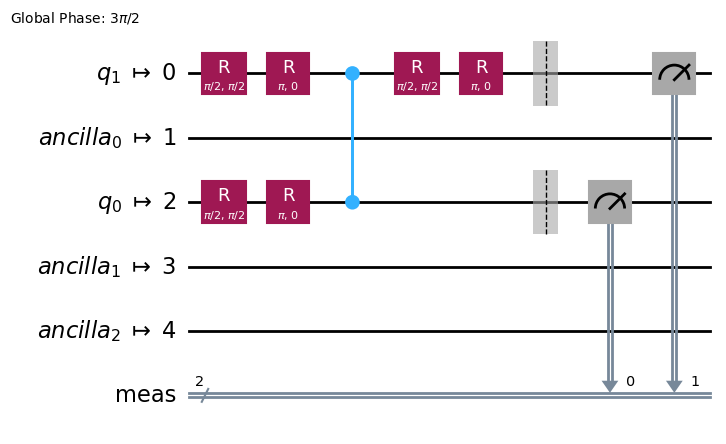

In [21]:
new_circuit = transpile(circuit,backend)
new_circuit.draw(output="mpl")

We can now submit the job to run. When submitting a job to Helmi a unique identifier for your job is returned. This can be used to gather additional information about the circuit you just submitted and the results. **You should save your job ids!**

In [20]:
job = backend.run(new_circuit)
print(f"Job ID: {job.job_id()}.")

Job ID: e7698727-a889-4c31-9b07-719376360bde.


## Viewing the results

Results can be printed once the job has completed. If results are queried before the job has completed then an error will be returned. 

e7698727-a889-4c31-9b07-719376360bde
{'10': 72, '11': 407, '00': 512, '01': 33}


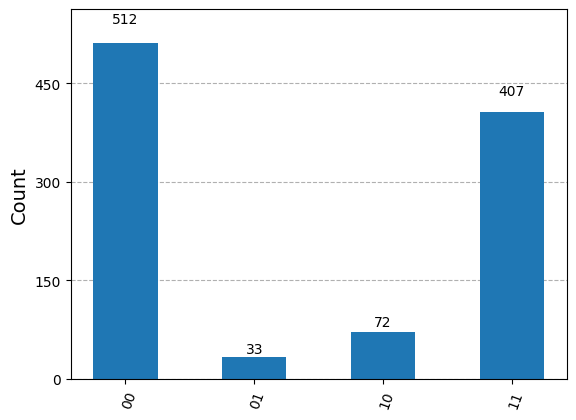

In [23]:
result = job.result()
print(result.job_id)  # The job id can be queried from the result
print(result.get_counts())
# print(result.get_memory())

plot_histogram(result.get_counts())

You can also specify some backend arguments for running on Helmi. These are explained in the [qiskit-on-iqm documentation](https://iqm-finland.github.io/qiskit-on-iqm/user_guide.html#installation).

In [ ]:
# job = backend.run(
#     circuit,
#     shots=100,
#     calibration_set_id="c5a5e2d1-100b-42d4-a4fd-a49edfb9d176",
#     max_circuit_duration_over_t2=1.0,
#     heralding_mode="zeros",
#     circuit_callback=None,
# )

After submitting, the job is now running. The status of the job can be queried using `job.status()`. Using the job id, you can retrieve previous jobs. 

In [24]:
status = job.status()
print(status)
# old_job = backend.retrieve_job(job_id)

JobStatus.DONE


### Explicit Transpilation

Instead of using the `execute` function you can also be explicit about your transpilation. 

For more control, you can also specify the initial layout in both `transpile` and `execute`. For example, Helmi's topology only allows 2 qubit gates between the central and outer qubits. Therefore we can map the 2 qubit gate to QB3.  For this we make use of the `QuantumRegister`. 

In [ ]:
qreg = QuantumRegister(2, "QB")
circuit = QuantumCircuit(qreg, name="Bell pair circuit")
circuit.h(qreg[0])
circuit.cx(qreg[0], qreg[1])
circuit.measure_all()


# Qubit numbers start at 0 index whereas the qubit names start at 1 index.
qubit_mapping = {
    qreg[0]: 1,  # Map the first qubit to QB1
    qreg[1]: 2,  # Map the second qubit to QB3
}


job = execute(circuit, backend, shots=100, initial_layout=qubit_mapping)

 Qiskit refers to qubits using integer indices, whereas IQM uses strings. The backend class provides utility methods for mapping them to one another. Let's see on which physical qubits the logical circuit qubits were mapped.

In [ ]:
mapping = {}
for qubit in circuit.qubits:
    index = circuit.find_bit(qubit).index
    mapping[index] = backend.index_to_qubit_name(index)

print(mapping)

## Optimizing circuits for Helmi

Qiskit on IQM provides the option to optimize your transpiled quantum circuits for running on Helmi. Currently the optimization uses Qiskit's transpiler passes to reduce the number of single qubit gates in the quantum circuit, thus reducing the total circuit depth. Further information can be found in the IQM qiskit documentation. 

Here we optimize the previous instance of `transpiled_circuit` as the `optimize_single_qubit_gates` expected a transpiled circuit as an argument. 

In [ ]:
circuit_optimized = optimize_single_qubit_gates(transpiled_circuit)
circuit_optimized.draw("mpl")

### Results

Results can be printed once the job has completed. If results are queried before the job has completed then an error will be returned. 

In [ ]:
result = job.result()
print(result.job_id)  # The job id can be queried from the result
print(result.get_counts())
# print(result.get_memory())

plot_histogram(result.get_counts())

Additional metadata about the executed job can also be found.

In [ ]:
exp_result = result._get_experiment(circuit)
print("Job ID: ", job.job_id())  # Retrieving the submitted job id
print(result.request.circuits)  # Retrieving the circuit request sent
print(
    "Calibration Set ID: ", exp_result.calibration_set_id
)  # Retrieving the current calibration set id.
print(result.request.qubit_mapping)  # Retrieving the qubit mapping
print(result.request.shots)  # Retrieving the number of requested shots.
print(exp_result.header)

### Simulating circuits locally with noise

[Qiskit on IQM](https://iqm-finland.github.io/qiskit-on-iqm/user_guide.html#noisy-simulation-of-quantum-circuit-execution) provides an `IQMFakeBackend` with `IQMFakeAdonis` for simulating Helmi. 

In [ ]:
from iqm.qiskit_iqm import IQMFakeAdonis

fake_backend = IQMFakeAdonis()
job = execute(circuit, fake_backend, shots=1000)
print(job.result().get_counts())
plot_histogram(job.result().get_counts())

The error profile of the noise can be queried and customised by the user following the qiskit-iqm user guide.

In [ ]:
print(fake_backend.error_profile)

In [ ]:
error_profile = fake_backend.error_profile
error_profile.t1s["QB1"] = 38940.0  # in ns 3.8940
error_profile.t1s["QB2"] = 25127.0  # in ns
error_profile.t1s["QB3"] = 43322.0  # in ns
error_profile.t1s["QB4"] = 38223.0  # in ns
error_profile.t1s["QB5"] = 37365.0  # in ns

error_profile.t2s["QB1"] = 24785.0  # in ns
error_profile.t2s["QB2"] = 20751.0  # in ns
error_profile.t2s["QB3"] = 10050.0  # in ns
error_profile.t2s["QB4"] = 14391.0  # in ns
error_profile.t2s["QB5"] = 29012.0  # in ns

error_profile.single_qubit_gate_depolarizing_error_parameters["prx"]["QB1"] = 0.0043
error_profile.single_qubit_gate_depolarizing_error_parameters["prx"]["QB2"] = 0.0018
error_profile.single_qubit_gate_depolarizing_error_parameters["prx"]["QB3"] = 0.0022
error_profile.single_qubit_gate_depolarizing_error_parameters["prx"]["QB4"] = 0.0037
error_profile.single_qubit_gate_depolarizing_error_parameters["prx"]["QB5"] = 0.0024

error_profile.two_qubit_gate_depolarizing_error_parameters["cz"][("QB1", "QB3")] = 0.018
error_profile.two_qubit_gate_depolarizing_error_parameters["cz"][("QB2", "QB3")] = 0.033
error_profile.two_qubit_gate_depolarizing_error_parameters["cz"][("QB3", "QB4")] = 0.030
error_profile.two_qubit_gate_depolarizing_error_parameters["cz"][("QB3", "QB5")] = 0.017

error_profile.single_qubit_gate_durations["prx"] = 120  # in ns
error_profile.two_qubit_gate_durations["cz"] = 120  # in ns

error_profile.readout_errors["QB1"]["0"] = 0.03375
error_profile.readout_errors["QB1"]["1"] = 0.03865
error_profile.readout_errors["QB2"]["0"] = 0.032
error_profile.readout_errors["QB2"]["1"] = 0.0520
error_profile.readout_errors["QB3"]["0"] = 0.0365
error_profile.readout_errors["QB3"]["1"] = 0.05885
error_profile.readout_errors["QB4"]["0"] = 0.03735
error_profile.readout_errors["QB4"]["1"] = 0.06225
error_profile.readout_errors["QB5"]["0"] = 0.04375
error_profile.readout_errors["QB5"]["1"] = 0.05689

error_profile.name = "fake_helmi"


helmi_fake_backend = fake_backend.copy_with_error_profile(error_profile)

In [ ]:
job = execute(circuit, helmi_fake_backend, shots=1000)
print(job.result().get_counts())
plot_histogram(job.result().get_counts())

### Batch execution

Helmi also allows for batches of circuits to be submitted with 1 call to the quantum computer. A batch is simply a list of `QuantumCircuits`. This is often faster than executing circuits individually, however, circuits will still be executed sequentially. On Helmi currently you can only place a maximum of 20 circuits in one batch. All circuits in a batch are executed with the same number of shots. The maximum number of shots per circuit is 100,000. 

All circuits in a batch must measure the same qubits. Adding the `initial_layout` argument when submitting ensures that you always measure the same qubits. 

Batch submission of circuits allows parameterized circuits to be executed using the [`qiskit.circuit.Parameter`](https://qiskit.org/documentation/stubs/qiskit.circuit.Parameter.html) class. 

In [ ]:
circuits_list = []

circuit_1 = QuantumCircuit(2, name="Bell pair circuit")
circuit_1.h(0)
circuit_1.cx(0, 1)
circuit_1.measure_all()
circuits_list.append(circuit_1)

circuit_1.draw(output="mpl")

In [ ]:
circuit_2 = QuantumCircuit(2, name="Reverse Bell pair circuit")
circuit_2.h(1)
circuit_2.cx(1, 0)
circuit_2.measure_all()
circuits_list.append(circuit_2)

circuit_2.draw(output="mpl")

In [ ]:
# Execute and monitor job
job = execute(
    circuits_list, backend, shots=10, optimization_level=3, initial_layout=[0, 2]
)
print("Tracking execution of job:")
job_monitor(job)

In [ ]:
# Get results
result = job.result()

# Plot histograms
plot_histogram(result.get_counts(), legend=["Circuit 1", "Circuit 2"])

## [Pennylane Qiskit](https://docs.pennylane.ai/projects/qiskit/en/latest/)

You can also run Pennylane code on Helmi with the [PennyLane-Qiskit Plugin](https://docs.pennylane.ai/projects/qiskit/en/latest/). The `IQMBackend` object uses `BackendV2` currently which Pennylane-Qiskit does not support, therefore we use a [forked-version](https://github.com/NordIQuEst/pennylane-qiskit) that fixes this. 

In [ ]:
import pennylane as qml

# provider = IQMProvider("https://qc.vtt.fi/helmi/cocos")
# backend = provider.get_backend()


dev = qml.device("qiskit.remote", wires=5, backend=backend, shots=10)

print(dev.capabilities())


@qml.qnode(dev, interface="autograd")
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.expval(qml.PauliZ(0))


print(circuit([0.54, 0.12]))

## Summary

In this notebook we have demonstrated how to connect and run circuits on Helmi with Qiskit, qiskit-on-iqm and the PennyLane-Qiskit plugin. 

## Additional Reading

- [Long-distance transmon coupler with CZ gate fidelity above 99.8%](https://arxiv.org/pdf/2208.09460.pdf). Paper by IQM describing the superconducting technology behind Helmi. 
- [Helmi press release](https://www.vttresearch.com/en/news-and-ideas/finlands-first-5-qubit-quantum-computer-now-operational). 
- [qiskit-on-iqm Github page](https://github.com/iqm-finland/qiskit-on-iqm).
- [qiskit-on-iqm documentation](https://iqm-finland.github.io/qiskit-on-iqm/).
- [CSC documentation on Helmi](https://docs.csc.fi/computing/quantum-computing/overview/).
- [Pennylane-Qiskit documentation](https://docs.pennylane.ai/projects/qiskit/en/latest/).